In [ ]:
# path, venv, git bash terminal useful commands:
cd C:/Users/marti/Desktop/AdventureWorks-msSQL-Python
# source .venv/Scripts/activate

# 1. Introduktion

# 2. Setup

## 2.1 Imports

Som i requirements.txt används följande python paket:

pandas, numpy, matplotlib, seaborn, sqlalchemy, pyodbc.

In [2]:
import pandas as pd, numpy as np, pyodbc
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus

## 2.2. Python och SQL: drivrutiner, connection och funktion

In [3]:
pyodbc.drivers()

['SQL Server',
 'ODBC Driver 18 for SQL Server',
 'Microsoft Access Driver (*.mdb, *.accdb)',
 'Microsoft Excel Driver (*.xls, *.xlsx, *.xlsm, *.xlsb)',
 'Microsoft Access Text Driver (*.txt, *.csv)',
 'Microsoft Access dBASE Driver (*.dbf, *.ndx, *.mdx)']

In [4]:
# quote_plus motverkar UTF-8 issues i connection.

user = "SA"
password = quote_plus(input(""))
server = "localhost:1433"
database = "AdventureWorks2025"
driver = quote_plus("ODBC Driver 18 for SQL Server")

connection_string = (
    f"mssql+pyodbc://{user}:{password}@{server}/{database}"
    f"?driver={driver}&Encrypt=yes&TrustServerCertificate=yes"
)

engine = create_engine(connection_string)

In [5]:
def query_df(sql: str):
    with engine.connect() as conn:
        return pd.read_sql(text(sql), conn)

# 3. Visualiseringar

## 3.1 Antal produkter per kategori

Hur många produkter finns i varje kategori?

* *Metod:* 

SQL query körs via en funktion i python som hämtar kolumner och rader från databasen, vilka sparas som en pandas dataframe. Matplotlib går utifrån insparad dataframe.

Eftersom Person.Person.ProductID är en primär nyckel med inkrement, behövs inte DISTINCT inom COUNT(Production.Product.ProductID). COUNT-beräkningen är en aggregerad funktion som är möjliggjord via GROUP BY utav kategorinamnen. Alltså räknar count alla närvarande produkt-id i queryn och visar hur många produkter som finns per kategori.

Tack vare LEFT JOIN, med Production.Product tabellen på vänster sida, räknar query 1 rader (produkter) som saknar ProductSubcategoryID såväl som produkter som är kategoriserade. En INNER JOIN skulle missat okategoriserade rader, som ändå python ta bort igen med slicing.

C:\Users\marti\AppData\Local\Temp\ipykernel_25224\4012941776.py:2: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  with engine.connect() as conn:


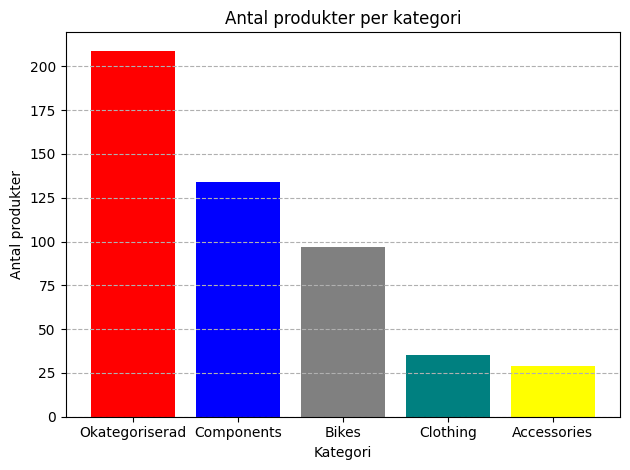


Kategori med flest produkter:
Kategori          Components
AntalProdukter           134
dtype: object

Kategori med minst produkter:
Kategori          Accessories
AntalProdukter             29
dtype: object


In [6]:
query_1 = """
SELECT ISNULL(ppc.Name, 'Okategoriserad') AS Kategori, 
            COUNT(pp.ProductID) AS AntalProdukter 
FROM Production.Product AS pp 
LEFT JOIN Production.ProductSubcategory AS pps 
    ON pp.ProductSubcategoryID = pps.ProductSubcategoryID 
LEFT JOIN Production.ProductCategory AS ppc 
    ON pps.ProductCategoryID = ppc.ProductCategoryID 
GROUP BY ppc.Name ORDER BY AntalProdukter DESC;"""

query_1_df = query_df(query_1) 
# display(query_1_df)

colors = ['red', 'blue', 'grey', 'teal', 'yellow']
plt.bar(query_1_df.Kategori, query_1_df['AntalProdukter'], color=colors) 
plt.title("Antal produkter per kategori") 
plt.xlabel("Kategori") 
plt.ylabel("Antal produkter") 
plt.grid(True, axis='y', linestyle="--") 
plt.tight_layout() 
plt.show()

# Sortera ut okategoriserade produkter med slicing:
query_1_df_mod = query_1_df.iloc[1:,:] 

# Printa flest & minst produkter
print("\nKategori med flest produkter:") 
print(query_1_df_mod.max())
print("\nKategori med minst produkter:") 
print(query_1_df_mod.min()) 

Ovan är en stapelgraf som visar olika stora produktkategorier utefter deras försäljning, följt av en specifikation av kategorier med flest och minst produkter.

Det går att lära sig mer detaljerade insikter, till exempel genom att inspektera okategoriserade produkter med en LEFT JOIN & WHERE IS NULL query, för då kan man t.ex. åtgärda att kategorisering saknas för vissa produkter med SQL's INSERT INTO VALUES. Givet, somliga produkter kanske inte ska lanseras. Queryn nedan tar fram okategoriserade produkter. En efterföljande query ger insikt i hur många produkter som slutat säljas.

In [7]:
query_1_bonus = """ 
SELECT pp.ProductID AS ProduktID, 
            pp.Name AS ProduktNamn, 
            pp.ProductSubcategoryID AS SubkategoriID, 
            pps.Name AS SubkategoriNamn, 
            ppc.Name AS KategoriNamn 
FROM Production.Product AS pp 
LEFT JOIN Production.ProductSubcategory AS pps 
    ON pp.ProductSubcategoryID = pps.ProductSubcategoryID 
LEFT JOIN Production.ProductCategory AS ppc 
    ON pps.ProductCategoryID = ppc.ProductCategoryID 
WHERE pp.ProductSubcategoryID IS NULL 
ORDER BY pp.ProductID;"""

query_1_bonus_df = query_df(query_1_bonus) 
query_1_bonus_df.tail(3)   # titta på sista 3 raderna

,ProduktID,ProduktNamn,SubkategoriID,SubkategoriNamn,KategoriNamn
206,534,Top Tube,None,None,None
207,535,Tension Pulley,None,None,None
208,679,Rear Derailleur Cage,None,None,None


Längden på resulterande tabell stämmer mot grafens stapel Okategoriserad.

Vidare insikter kan komma ifrån att granska frekvens av kategorier med aktiva och utgångna produkter.

In [8]:
query_1_active = """ 
SELECT ISNULL(ppc.Name, 'Okategoriserad') AS Kategori, 
        COUNT(pp.ProductID) AS AntalProdukter 
FROM Production.Product AS pp 
LEFT JOIN Production.ProductSubcategory AS pps 
    ON pp.ProductSubcategoryID = pps.ProductSubcategoryID 
LEFT JOIN Production.ProductCategory AS ppc 
    ON pps.ProductCategoryID = ppc.ProductCategoryID 
WHERE pp.SellEndDate IS NULL GROUP BY ppc.Name 
ORDER BY AntalProdukter DESC; """

query_1_active_df = query_df(query_1_active) 
diff = query_1_df.AntalProdukter - query_1_active_df.AntalProdukter 
query_1_active_copy = query_1_active_df.copy() 
query_1_active_copy['Differens'] = diff 
query_1_active_copy['HistoriskaOchAktivaProdukter'] = query_1_df.AntalProdukter 
query_1_active_copy

,Kategori,AntalProdukter,Differens,HistoriskaOchAktivaProdukter
0,Okategoriserad,209,0,209
1,Components,95,39,134
2,Bikes,60,37,97
3,Accessories,22,13,35
4,Clothing,20,9,29


I resulterande tabell med tillagd kolumn Differens via python-kod (visar antalet inaktiva produkter), som givetvis skulle gå att ta fram via SQL query också, ser vi att inaktiva produkter inom Components är 39st, och så vidare. Alltså är potentiellt LEFT JOIN + WHERE pp.SellEndDate IS NULL ett välbehövligt filter för query 1 ifall inaktiva produkter ska borträknas i kategoriuppdelningen.

## 3.2 Försäljning per produktkategori

Vilka produktkategorier genererar mest intäkter?

* *Metod:* 

SQL's INNER JOIN som fångar upp sålda produkter sammanfogar Product, ProductSubcategory och SalesOrderDetail-tabellerna, vi grupperar efter kategori och summerar omkostnaden (kolumn LineTotal). Då erhålles en dataframe som går att göra plots på. Vi gör en förfinad tabell beaktandes kategoriserade produkter (mer utvecklad query än förstkommande), som även beräknar värden för nuvarande aktiva produkter och differens mot inklusive inaktiva produkters försäljning, alltså inräknad historik. 

In [9]:
query_2 = """ 
SELECT ppc.Name AS Kategori, 
        SUM(ssod.LineTotal) AS TotalFörsäljning 
FROM Production.ProductCategory AS ppc 
INNER JOIN Production.ProductSubcategory AS pps 
    ON ppc.ProductCategoryID = pps.ProductCategoryID 
INNER JOIN Production.Product AS pp 
    ON pps.ProductSubcategoryID = pp.ProductSubcategoryID 
INNER JOIN Sales.SalesOrderDetail AS ssod 
    ON pp.ProductID = ssod.ProductID 
GROUP BY ppc.Name 
ORDER BY TotalFörsäljning DESC; """
query_2_df = query_df(query_2) 
# query_2_df


# Mer utvecklad version
query_2_active = """ 
SELECT ppc.Name AS Kategori, 
        SUM(ssod.LineTotal) AS TotalFörsäljning 
FROM Production.ProductCategory AS ppc 
INNER JOIN Production.ProductSubcategory AS pps 
    ON ppc.ProductCategoryID = pps.ProductCategoryID 
INNER JOIN Production.Product AS pp 
    ON pps.ProductSubcategoryID = pp.ProductSubcategoryID 
INNER JOIN Sales.SalesOrderDetail AS ssod 
    ON pp.ProductID = ssod.ProductID 
WHERE pp.SellEndDate IS NULL 
GROUP BY ppc.Name
ORDER BY TotalFörsäljning DESC;"""

query_2_active_df = query_df(query_2_active)
diff = query_2_df.TotalFörsäljning - query_2_active_df.TotalFörsäljning 
query_2_active_copy = query_2_active_df.copy() 
query_2_active_copy['Differens'] = diff.round(0).astype(int) 
query_2_active_copy['HistoriskFörsäljning'] = query_2_df.TotalFörsäljning.round(0).astype(int) 
query_2_active_copy['TotalFörsäljning'] = query_2_active_copy['TotalFörsäljning'].round(0).astype(int)

print("Här är en presentationsvänlig tabell på försäljning per kategori:") 
display(query_2_active_copy) 
print("Differens beskriver storleken på försäljning på produkter som slutat säljas.")

Här är en presentationsvänlig tabell på försäljning per kategori:


,Kategori,TotalFörsäljning,Differens,HistoriskFörsäljning
0,Bikes,61069197,33581976,94651173
1,Components,9468393,2334200,11802593
2,Clothing,1531721,588821,2120543
3,Accessories,1242318,29755,1272073


Differens beskriver storleken på försäljning på produkter som slutat säljas.


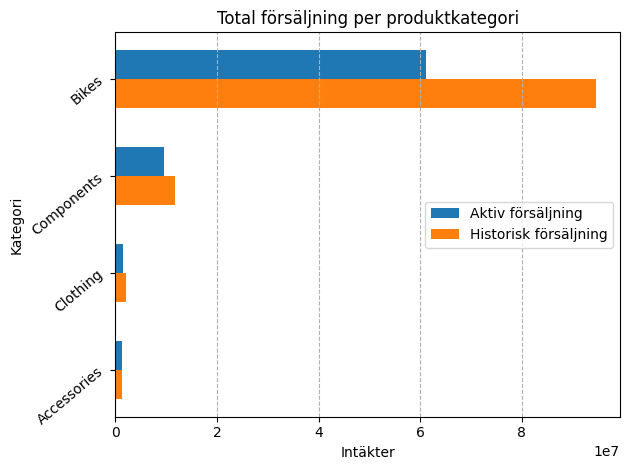

Högst försäljning: 94651172.704731,
Och för aktiva produkter: 61069196.787288
-----------------------------------------
Lägst försäljning: 1272072.883926,
Och för aktiva produkter: 1242317.97665


In [10]:
cols = ['TotalFörsäljning','HistoriskFörsäljning'] # behöver sortera som stigande, för barh plot ska ha högst överst.
ascending_df = query_2_active_copy.copy().sort_values(by=cols, ascending=True) # använder den förfinade tabellen
categories = ascending_df['Kategori'] # plockar ut kolumner som ska plottas till variabler
active_sales = ascending_df['TotalFörsäljning']
historic_sales = ascending_df['HistoriskFörsäljning']
length = len(ascending_df) # hur många staplar ska plottas
y = np.arange(length) 
width = 0.3

plt.figure()
plt.barh(y + width/2, active_sales, width, label='Aktiv försäljning')
plt.barh(y - width/2, historic_sales, width, label='Historisk försäljning')

plt.yticks(y, categories, rotation=40)
plt.ylabel('Kategori')
plt.xlabel('Intäkter')
plt.title("Total försäljning per produktkategori")
plt.legend(loc='center right')
plt.grid(True, axis='x', linestyle="--")
plt.tight_layout()
plt.show()

print(f"""Högst försäljning: {query_2_df.TotalFörsäljning[0]},
Och för aktiva produkter: {query_2_active_df.TotalFörsäljning[0]}""")
print("-----------------------------------------")
print(f"""Lägst försäljning: {query_2_df.TotalFörsäljning[len(query_2_df)-1]},
Och för aktiva produkter: {query_2_active_df.TotalFörsäljning[len(query_2_active_df)-1]}""") 
# len() för att ta sista indexplatsen, alltså lägsta siffran.

Visualiseringen visar beaktar historiska totala-, och aktiva produkters totala försäljning, följt av en specifikation av exakta siffrorna för högst respektive lägst försäljning, som tillfaller kategorin cyklar och accessoarer (oavsett aktivitetsfiltret).

Det går att lära sig flera saker här.

* Kategorier med högst intäkter är beroende av produkternas kvantiteter sålda och deras priser, och där är vinstmarginal och kostnadsstruktur viktig för sådan analys. Cyklar är dyra vilket driver på den figuren som är högst.

* Fråga 2 berör intäkter, och inte ens över tid, vilket två följande delkapitel handlar om. Geografiska intäkter gås igenom i **3.7**.

* Exempelvis validering av data kan göras med LEFT JOIN query för att se okategoriserade produkter som har sett försäljning, för att inte missa intäkter i våra beräkningar.
    * Resten av detta delkapitel behandlar denna valideringsfråga.

In [11]:
query_2_left = """ 
SELECT pp.ProductID AS ProduktID, 
        pp.Name AS ProduktNamn, 
        pps.Name AS SubkategoriNamn, 
        ppc.Name AS KategoriNamn, 
        SUM(ssod.LineTotal) AS TotalFörsäljning 
FROM Production.Product AS pp 
LEFT JOIN Production.ProductSubcategory AS pps 
    ON pp.ProductSubcategoryID = pps.ProductSubcategoryID 
LEFT JOIN Production.ProductCategory AS ppc 
    ON pps.ProductCategoryID = ppc.ProductCategoryID 
LEFT JOIN Sales.SalesOrderDetail AS ssod 
    ON pp.ProductID = ssod.ProductID 
GROUP BY ppc.Name, pps.Name, pp.Name, pp.ProductID 
ORDER BY TotalFörsäljning DESC; """

query_2_left_df = query_df(query_2_left) 
display(query_2_left_df.tail(3)) # titta på sista 3 raderna

,ProduktID,ProduktNamn,SubkategoriNamn,KategoriNamn,TotalFörsäljning
501,679,Rear Derailleur Cage,None,None,NaN
502,680,"HL Road Frame - Black, 58",Road Frames,Components,NaN
503,706,"HL Road Frame - Red, 58",Road Frames,Components,NaN


In [12]:
# python overview av query_2_left_df
print("Här är hur många rader som saknar kategori men ändå haft försäljning: ", len(
    query_2_left_df[(query_2_left_df['KategoriNamn'].isna()) & 
                    (query_2_left_df['TotalFörsäljning'] > 0)])) # blir noll 

Här är hur många rader som saknar kategori men ändå haft försäljning:  0


Validering av okategoriserade produkter som sett försäljning:

Eftersom alla okategoriserade produkter har NaN i TotalFörsäljning, är slutsatsen att INNER JOIN räcker för intäktsanalysen. Okategoriserade produkter kan härstamma som prototyper, icke-lanserade, reservdelar eller produkter som används inuti företaget.

## 3.3 Försäljningstrend över tid

Hur har försäljningen utvecklats över tid?

* *Metod:* 

Inga JOINs är aktuella, då vi har datum och siffror såsom totalkostnad inklusive moms per order i denna tabellen. Vi specificerar SELECT med önskade kolumner och kollar efter NaN, som visades saknas. Query_3 kommenteras ut, och query_3_agg räknar ihop ordervärden per månad, vilket plottas tillsammans med rullande medelvärde på 3 månader. X-axelns visade värden får presenteras uppdelat, och med lite rotation. Vi håller oss till analys som bortser från frakt, skatt och omkostnad exklusive moms. Förvisso kan det aggregeras siffror för sådana mätvärden över tidsperioden, medan analysen blir tillräcklig utan att gå in på de detaljerna.

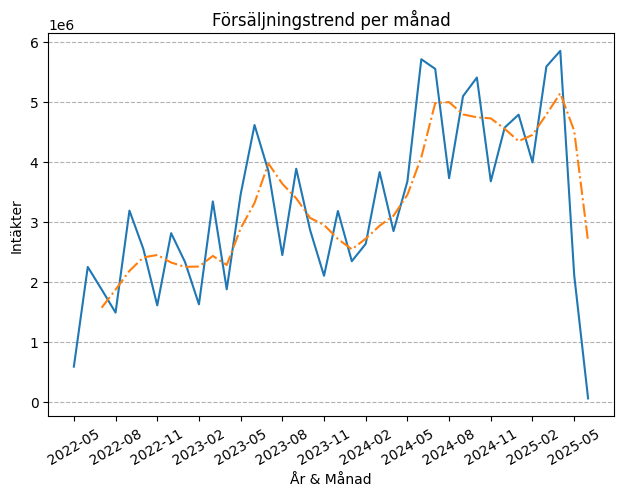


---------------------------------------------------------------------------
Högsta försäljningssiffran och aktuell månad: 5847164.7, 2025-04

Lägsta försäljningssiffran och aktuell månad: 52478.2, 2025-06



In [13]:
query_3 = """
SELECT OrderDate,
        TotalDue
FROM Sales.SalesOrderHeader
"""
query_3_df = query_df(query_3)
# display(query_3_df.tail(4))
# display(query_3_df.info()) # inga rader är NaN.

# print(query_3_df.OrderDate.min()) # kika på tidigaste och senaste datum.
# print(query_3_df.OrderDate.max())

# Ordrarna är i stigande ordning, 
# 2022-05-30 är första datum.
# 2025-06-29 är sista datum.

query_3_agg = """
SELECT FORMAT(OrderDate, 'yyyy-MM') AS Månad,
        SUM(TotalDue) TotalFörsäljning
FROM Sales.SalesOrderHeader
GROUP BY FORMAT(OrderDate, 'yyyy-MM')
ORDER BY Månad"""

query_3_agg_df = query_df(query_3_agg)
# query_3_agg_df.tail(4) # visar sista 4 månaderna


plt.figure()
plt.plot(query_3_agg_df.Månad, query_3_agg_df.TotalFörsäljning)
plt.title("Försäljningstrend per månad")
plt.xlabel("År & Månad")
plt.ylabel("Intäkter")
plt.tight_layout()
plt.grid(True, axis='y', linestyle="--")
plt.xticks(query_3_agg_df.Månad[::3], rotation=30)
plt.plot(query_3_agg_df.Månad, query_3_agg_df.TotalFörsäljning.rolling(3).mean(), label="Glidande medelvärde",
         linestyle="-.")
plt.show()

print("\n---------------------------------------------------------------------------")
max_sales = query_3_agg_df.loc[query_3_agg_df.TotalFörsäljning.idxmax()]
min_sales = query_3_agg_df.loc[query_3_agg_df.TotalFörsäljning.idxmin()]
print(f"Högsta försäljningssiffran och aktuell månad: {max_sales.TotalFörsäljning.round(1)}, {max_sales.Månad}\n")
print(f"Lägsta försäljningssiffran och aktuell månad: {min_sales.TotalFörsäljning.round(1)}, {min_sales.Månad}\n")

Ovan är en graf med månadsvis aggregering av försäljningssiffrorna, inklusive historiska och aktiva produkter.

Ett glidande medelvärde med 3 månader lagg låter oss se trendutvecklingen, som annars också skulle kunna fås fram genom att aggregera flera månader till samma datapunkt med medelvärden av intäkterna.

En strikt linje från början av grafen, till slutet (innan det dramatiska fallet som påbörjas efter maximum vid 2025-04) skulle visa en stadigt stigande trend. Detta görs med linjär regression, dock inte i denna studie.

De två andra vassa topparna, förutom den sista längst till höger, skedde under månad 5 och 6 under de åren, så visst säsongsmönster finns fastän de flesta dalar är lite oregelbundna (inte jämnt ökande med intäkter).

Att den månadsvisa aggeregerade grafen är volatil öppnar ändå för frågan om försäljningssiffrorna är säsongsberoende, som är knepigt att direkt läsa av månadsvisa försäljningsgrafen ovan. Om statistiska mått involveras såsom medelvärde, median, och procentskillnader går det att nå fram till uppskatning av vilken grad siffrorna är säsongsbundna, och om tillväxten är linjär blir säsongernas mönster enklare att bedöma.

Det går vidare att lära sig om säsongsberoende mönster, exempelvis genom att se hur månader, 3 emellan, ser ut på egna grafer, vilket testas nedan.

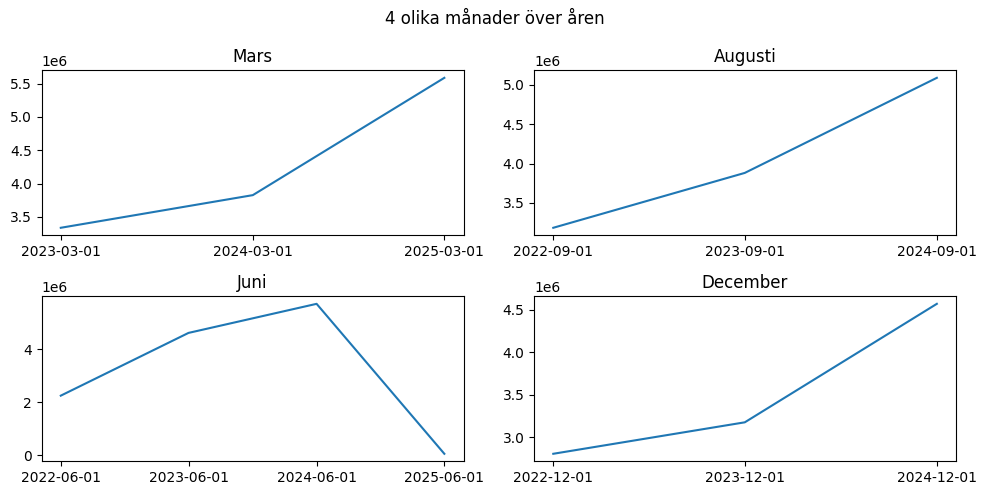

In [14]:
query_3_agg_df.Månad = pd.to_datetime(query_3_agg_df.Månad)
query_3_agg_df['MånadNummer'] = query_3_agg_df.Månad.dt.month

mars = query_3_agg_df[query_3_agg_df.MånadNummer == 3 ] # här kan man lägga till -1, eller -2, så ser man andra månader.
juni = query_3_agg_df[query_3_agg_df.MånadNummer == 6 ]
aug = query_3_agg_df[query_3_agg_df.MånadNummer ==  9 ]
dec = query_3_agg_df[query_3_agg_df.MånadNummer ==  12]

fig, axes = plt.subplots(2,2, figsize=(10,5))
plt.suptitle("4 olika månader över åren")
axes[0,0].plot(mars.Månad, mars.TotalFörsäljning)
axes[0,0].set_xticks(mars.Månad)
axes[0,0].set_title("Mars")

axes[1,0].plot(juni.Månad, juni.TotalFörsäljning)
axes[1,0].set_xticks(juni.Månad)
axes[1,0].set_title("Juni")

axes[0,1].plot(aug.Månad, aug.TotalFörsäljning)
axes[0,1].set_xticks(aug.Månad)
axes[0,1].set_title("Augusti")

axes[1,1].plot(dec.Månad, dec.TotalFörsäljning)
axes[1,1].set_xticks(dec.Månad)
axes[1,1].set_title("December")
plt.tight_layout()

Med kodcellen ovan kan man testa årets 12 månader, 3 månader emellan i graferna. Det finns 3, ibland 4, år med historisk data för månaderna, som kanske inte räcker för att säkerställa att försäljningen är säsongsbunden. Till detta så noteras även att ingen månad hade konsekvent förhöjda intäkter återkommande, vilket dock kan otydliggöras med vetskapen att intäkterna har ökat från start till nästan slutet på datasetet. Andra aggregeringar, såsom ifall två till fyra månader skulle slås samman, skulle kanske visuellt samband kunna framstå. 

## 3.4 Försäljning och antal ordrar per år

Hur ser total försäljning och antal ordrar ut per år?

* *Metod:* 

I början grupperar vi försäljning och ordrar efter år, och inser att första och sista halvåren räknas till egna helår. Denna kod kommenteras ut och följs upp med linjegraf med anpassning till helår förgågna i datasetet (att ett år har gått 2023-05-30). Anpassat dataset på detta vis sammanfaller bättre med en månadsvis linjegraf, som är den sista presenterade visualiseringen i detta delkapitel. Efter första grafen visas försäljning (på det anpassade sättet) med vertikal grupperad stapelgraf, år för år gällande försäljning och antal ordrar. Även följer bästa och sämst presterande åren presenterade numeriskt med stapelgrafen. Efter den är en linjegraf som visar ordrar och försäljning per månad, för att se trendutveckling.

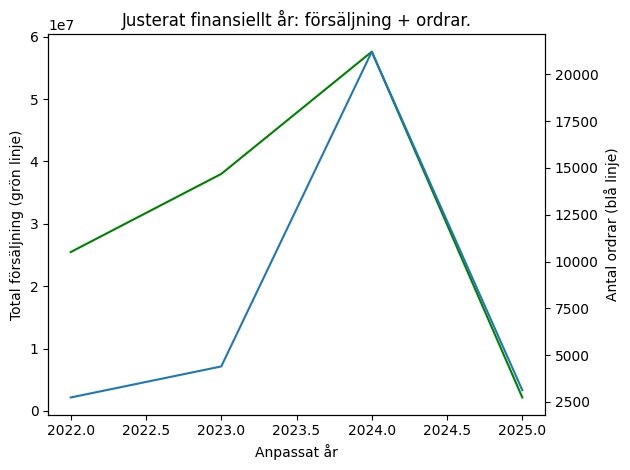

In [15]:
q4 = """
SELECT YEAR(OrderDate) AS År,
        CAST(ROUND(SUM(TotalDue),0) AS INT) TotalFörsäljning,
        COUNT(*) AS AntalOrdrar
FROM Sales.SalesOrderHeader
GROUP BY YEAR(OrderDate)
ORDER BY År"""

q4_df = query_df(q4)
# q4_df

#  Python kan plotta q4_df.
# -----------------------------------  Utkommenterat
# fig, ax = plt.subplots()
# ax.plot(q4_df.År, q4_df.TotalFörsäljning, color="green")
# ax.set_xlabel("År")
# ax.set_ylabel("Total försäljning (grön linje)")

# ax2 = ax.twinx() # sekundär y-axel, då ordrar är i tiotusen och försäljning på tiotals miljoner.
# ax2.plot(q4_df.År, q4_df.AntalOrdrar)
# ax2.set_ylabel("Antal ordrar (blå linje)")

# plt.title("Försäljning + ordrar, med endast halva år 2022 och 2025.")
# plt.show()

#  KOMMENTAR: (täcks utav resten av delkapitlet, så denna är överflödig)
# Ovan är en sammanställning av årens försäljning (grön linje) och antal ordrar (blå linje), 
# notera att första och sista året är endast halvår med försäljning. För att simulera kompletta försäljningsår 
# skulle det kanske gå att dubblera värdena på första och sista raden. Vid snabb granskning verkar siffrorna vara 
# stadigt stigande på det sättet, fastän försäljningen var avvikande låg mot slutet av tiden. Alternativt skulle 
# beräkningar gå att göra såsom att låta juni 2022 till juni 2023 räknas som första året, och så vidare. 
# På så vis skulle man räkna hela år, vilket också skulle ha en ökande försäljningstrend medan en skarp dipp äger rum mot slutet av tiden. 
# I praktiken går det att dela in datum-grupperad försäljning på 3 hela år då starten är maj 2022 till juni 2025. 
# Dessa anmärkningar är bra att känna till för att kunna analysera datasetet korrekt.
# ----------------------------------- 

# Återkalla tidigare query_3_agg, som ger 38st månader med data.
# lägger till AntalOrdrar.
query_3_agg = """
SELECT FORMAT(OrderDate, 'yyyy-MM') AS Månad,
        SUM(TotalDue) TotalFörsäljning,
        COUNT(*) AS AntalOrdrar
FROM Sales.SalesOrderHeader
GROUP BY FORMAT(OrderDate, 'yyyy-MM')
ORDER BY Månad"""

query_3_agg_df = query_df(query_3_agg)
query_3_agg_df.Månad = pd.to_datetime(query_3_agg_df.Månad)
query_3_agg_df['MånadNummer'] = query_3_agg_df.Månad.dt.month
# query_3_agg_df.head(2)

# Python kan gruppera query_3_agg med ordrar, över anpassade helår.
query_3_agg_df["AnpassatÅr"] = query_3_agg_df["Månad"].apply(lambda x: x.year if x.month >= 5 else x.year - 1)
adapt_year_df = (query_3_agg_df.groupby("AnpassatÅr")[["TotalFörsäljning", "AntalOrdrar"]].sum().reset_index())
# adapt_year_df

# Med troligen samma resultat kan SQL query med CASE ge oss:
q4_agg = """
SELECT
    CASE
        WHEN MONTH(OrderDate) >= 5 THEN YEAR(OrderDate)
        ELSE YEAR(OrderDate) - 1
    END AS AnpassatÅr,
    SUM(TotalDue) AS TotalFörsäljning,
    COUNT(*) AS AntalOrdrar
FROM Sales.SalesOrderHeader
GROUP BY 
    CASE 
        WHEN MONTH(OrderDate) >= 5 THEN YEAR(OrderDate)
        ELSE YEAR(OrderDate) - 1
    END
ORDER BY AnpassatÅr"""
q4_agg_df = query_df(q4_agg)
# q4_agg_df
# Tabellerna ovan stämde överens, så både python och sql kan framkalla anpassad data.

fig, ax = plt.subplots()

ax.plot(adapt_year_df["AnpassatÅr"], adapt_year_df["TotalFörsäljning"], color='green')
ax.set_xlabel("Anpassat år")
ax.set_ylabel("Total försäljning (grön linje)")

ax2 = ax.twinx()
ax2.plot(adapt_year_df["AnpassatÅr"], adapt_year_df["AntalOrdrar"])
ax2.set_ylabel("Antal ordrar (blå linje)")

plt.title("Justerat finansiellt år: försäljning + ordrar.")
plt.tight_layout()

Jämfört med första (utkommenterad) skissad graf i denna uppgiften, faller nu ordrar och försäljning mycket mer i tandem, en effekt som kommer från hur finansiella åren är inarbetade i analysen.


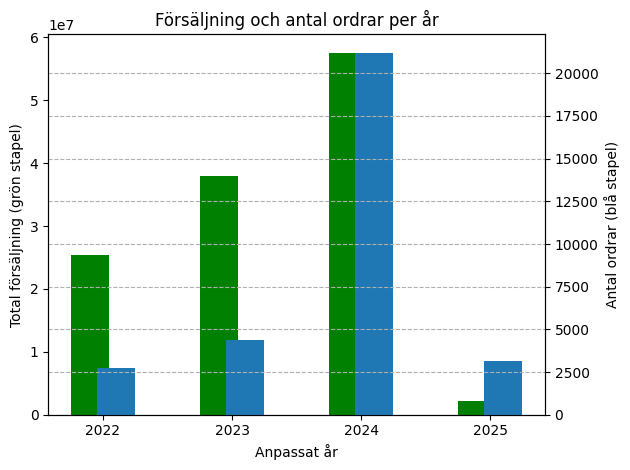

-------------------------------------
Högst försäljning: 57587486, år 2024
-------------------------------------
Lägst försäljning: 2160884, år 2025
-------------------------------------
Flest ordrar: 21213, år 2024
----------------------------
Lägst ordrar: 2735, år 2022


In [16]:
x = np.arange(len(adapt_year_df))

fig, ax = plt.subplots()
ax.bar(x - width/3, adapt_year_df["TotalFörsäljning"], width=0.3, color='green')
ax.set_xlabel("Anpassat år")
ax.set_ylabel("Total försäljning (grön stapel)")

ax2 = ax.twinx()
ax2.bar(x + width/3, adapt_year_df["AntalOrdrar"], width=0.3)
ax2.set_ylabel("Antal ordrar (blå stapel)")

ax.set_xticks(x)
ax.set_xticklabels(adapt_year_df["AnpassatÅr"])
plt.title("Försäljning och antal ordrar per år")
plt.tight_layout()
plt.grid(True, axis='y', linestyle='--')
plt.show()

# Winners & Losers..
max_sales = q4_agg_df.loc[q4_agg_df.TotalFörsäljning.idxmax()]
min_sales = q4_agg_df.loc[q4_agg_df.TotalFörsäljning.idxmin()]
max_orders = q4_agg_df.loc[q4_agg_df.AntalOrdrar.idxmax()]
min_orders = q4_agg_df.loc[q4_agg_df.AntalOrdrar.idxmin()]

print("-------------------------------------")
print(f"""Högst försäljning: {max_sales.TotalFörsäljning.round(0).astype(int)}, år {max_sales.AnpassatÅr.astype(int)}""")
print("-------------------------------------")
print(f"""Lägst försäljning: {min_sales.TotalFörsäljning.round(0).astype(int)}, år {min_sales.AnpassatÅr.astype(int)}""")
print("-------------------------------------")
print(f"""Flest ordrar: {max_orders.AntalOrdrar.astype(int)}, år {max_orders.AnpassatÅr.astype(int)}""")
print("----------------------------")
print(f"""Lägst ordrar: {min_orders.AntalOrdrar.astype(int)}, år {min_orders.AnpassatÅr.astype(int)}""")

Ovan visar, givet 2025 är ett nyligen påbörjat år, att lägst försäljning sker på det ofulländade anpassade året. Lägst ordrar tillfaller första hela året så det mätvärdet har ökat via anpassningen. Försäljning- och ordertrenden är beroende på hur 2025 fortsätter så kan vi se om tillväxten är hållbar eller om nedsaktandet mot slutet av perioden håller i sig. Med dessa få årtal att döma ifrån, är det ändå en positiv stark uppåttrend inledningsvis.

Det som går att läras ifrån denna analys är att vid jämförelse utav en linjegraf av försäljningsdata med anpassad aggregering och en icke-anpassad tabell med 2st halvår (första och sista raderna), kanske framhäver tydligare trender för att komplettera trendmönster-diskussionen i *uppgift 3* som testade mars + juni + okt + dec, och visualisera effekten av halvårs-räknade finansiella år. Med flera visualiseringar kan flera utsagor göras, och mönster som döljer sig för den ena kanske visas i den andra. 

Ytterligare en insikt att databaskännedom kan involvera *caveats* som är bra att känna till för att kunna analysera datasetet korrekt. 

En sista insikt från månadsvisa linjegrafen som följer är att försäljning var rätt spikigt och orderantalen rätt stabila första grafhalvan till vänster, medan de rör sig mera i tandem andra halvan. Sådana här dynamiker syntes inte till i årsgrupperad tabell.

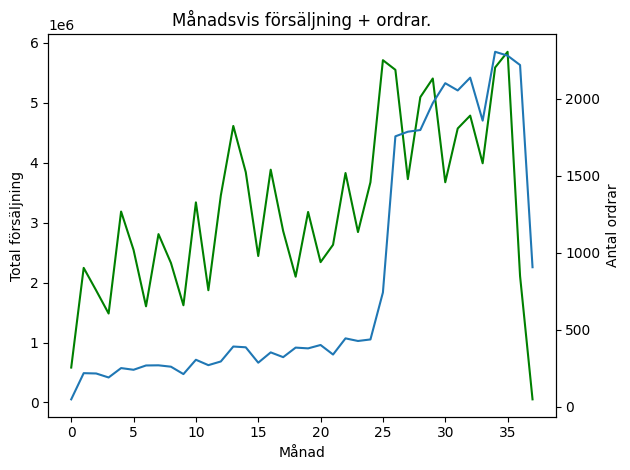

In [17]:
# Här är samma linjegraf som i uppgift 3, men med ordrar per månad inlagda.
x = range(len(query_3_agg_df)) # fixa månadnummer på x axeln

fig, ax = plt.subplots()
ax.plot(x, query_3_agg_df["TotalFörsäljning"], color='green')
ax.set_xlabel("Månad")
ax.set_ylabel("Total försäljning")

ax2 = ax.twinx() # sekundär y-axel
ax2.plot(x, query_3_agg_df["AntalOrdrar"])
ax2.set_ylabel("Antal ordrar")

plt.title("Månadsvis försäljning + ordrar.")
plt.tight_layout()

Som nämnt ovan att orderantal och spikig försäljning inte ser ut att vara helt knutna till varandra genom hela grafen. Med andra ord, i månadsvisa linjegrafen syns till vänster att antal ordrar inte behöver driva försäljningskurvan, samtidigt som på våren 2024 ökar ordrar och försäljning och även slutet av datasettet faller både försäljning och antalet ordrar. Detta tillhör inte helårs-analysen av denna uppgiften men skiner ändå ljus på intressant dynamik.

## 3.5 Top 10 produkter

Vilka 10 produkter genererar mest försäljning?

* *Metod:* 

Först ger jag slutlig query och visualisering, följt av kommentar. Därefter ges stegvisa approachen i kodceller. Det ingick stringmanipulering i SELECT för att få separerat produkterna så de kan grupperas. Nämligen fanns flera storlekar, och även färger, som jag inte grupperat ihop fastän det är ett rimligt förfarande. Det är lite tekniskt dock, på så vis att hur produktnamnen är skrivna och de SQL string funktioner som finns till hands, dock går det att lösa med SQL eller python till exempel med CASE.

Produkt             Mountain-200 Black
SubKategori             Mountain Bikes
TotalFörsäljning       11719760.779149
Name: 0, dtype: object


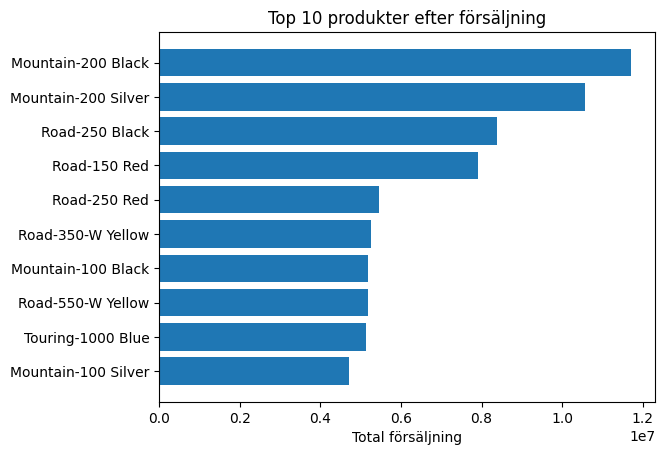

In [18]:
q5_string = """
SELECT TOP 10
    LEFT(pp.Name, CHARINDEX(',', pp.Name)-1) AS Produkt,
    pps.Name AS SubKategori,
    SUM(ssod.LineTotal) AS TotalFörsäljning
FROM Production.Product pp
INNER JOIN Sales.SalesOrderDetail ssod
    ON pp.ProductID = ssod.ProductID
INNER JOIN Production.ProductSubcategory pps
    ON pp.ProductSubcategoryID = pps.ProductSubcategoryID
WHERE CHARINDEX(',', pp.Name) > 0
GROUP BY LEFT(pp.Name, CHARINDEX(',', pp.Name) - 1), pps.Name
ORDER BY TotalFörsäljning DESC;"""
q5_string_df = query_df(q5_string)
# display(q5_string_df)

# Topp produkten och exakt försäljningssiffra, alla storlekar på produkten ihopräknade:
print(q5_string_df.iloc[0])

# Som uppgift 4 behöver vi sortera som stigande för barh plot ska ha högst överst.
ascending_df = q5_string_df.copy().sort_values('TotalFörsäljning', ascending=True)

plt.figure()
plt.barh(ascending_df.Produkt, ascending_df.TotalFörsäljning)
plt.xlabel('Total försäljning')
plt.title("Top 10 produkter efter försäljning")
plt.show()

Denna graf visar produkter och deras försäljning, som en topp-10 lista. 

Ovanför horisontella stapelgrafen syns topp-produkten och hur mycket den sålt för (inte storlek för storlek utan totalt). Kategorin är **Bikes**, och den kategorin är alla 10 toppsäljande produkter tillhörande, alltså den fullt dominanta kategorin. Det går att koppla på Production.ProductCategory-tabellen med JOIN för att se kategorinamn, medan sub-kategori valdes att visas i tabellen ovan för presentationsvänlighet. Det är viktigt att nämna att färgerna inte har sammanfogats, något som kan vara lite avancerat utefter hur produkterna är skriftligt inlagda i databasen.

Det finns mycket att lära kring topp-presterande produkter, analys som kan sträcka sig över tid, geografiskt och även i klassificering. Sub-kategorier kanske är kanske specifikt nog för viss analys, medan produkt med såväl storlek som färg kan vara viktig att hålla isär. Även kan man dyka ner i försäljning av aktiva och nedlagda produkter, som innan.

Nedan följer hur ovanför nåddes fram till, stegvis. Där följer en insikt: *Road Bikes säljer mera som subkategori än Mountain Bikes, medan Mountain Bikes har en sådan produkt som högstsäljande.*

In [19]:
#SELECT TOP 5 *
#FROM Production.Product;
#SELECT TOP 5 *
#FROM Sales.SalesOrderDetail

# TAR FRAM PRODUKTER SOM ÄR SEPARERADE MED FÄRG OCH STORLEK..
q5 = """
SELECT TOP 8 pp.Name AS Produkt,
        pps.Name AS SubKategori,
        SUM(ssod.LineTotal) AS TotalFörsäljning
FROM Production.Product pp
INNER JOIN Sales.SalesOrderDetail ssod
    ON pp.ProductID = ssod.ProductID
INNER JOIN Production.ProductSubcategory pps
    ON pp.ProductSubcategoryID = pps.ProductSubcategoryID
GROUP BY pp.Name, pps.Name
ORDER BY TotalFörsäljning DESC;
"""
q5_df = query_df(q5)
# q5_df

Produktnamnen anger problematiskt även storlekar på cyklar, och vi går inte in på jämförelse mot produkter som säljs eller avvecklats via SQL's WHERE såsom i *uppgift 2*, så nu testar vi en query som ger topp 10 subkategorier:

In [20]:
q5_sub = """
SELECT TOP 10 pps.Name AS SubKategori,
        SUM(ssod.LineTotal) AS TotalFörsäljning
FROM Production.Product pp
INNER JOIN Sales.SalesOrderDetail ssod
    ON pp.ProductID = ssod.ProductID
INNER JOIN Production.ProductSubcategory pps
    ON pp.ProductSubcategoryID = pps.ProductSubcategoryID
GROUP BY pps.Name
ORDER BY TotalFörsäljning DESC;"""

q5_sub_df = query_df(q5_sub)
q5_sub_df.head(3)

,SubKategori,TotalFörsäljning
0,Road Bikes,4.390944e+07
1,Mountain Bikes,3.644544e+07
2,Touring Bikes,1.429629e+07


Detta är mera överskådligt men svarar inte riktigt på uppgiften. Notera även att Road Bikes säljer mera som subkategori än Mountain Bikes, medan Mountain Bikes har en sådan produkt som högstsäljande. Därför går vi vidare med string-manipulation i SQL's SELECT (python kan också utgå ifrån q5_df och ordna denna biten men SQL är nu fokus).

## 3.6 Försäljning och antal kunder per region

Hur skiljer sig försäljningen mellan olika regioner, och hur många unika kunder har varje region?

* *Metod:* 

Query ska sätta ihop med INNER JOIN och gruppera efter land och region (som anskaffas med concat i SELECT), då t.ex. North annars kan klumpas ihop med annat land. Sorterar bara försäljning fallande, och det görs summering på orderkostnader och räkning på unika antalet kunder görs sedan, och dataframen som fås kan göras till sorterad grupperad stapelgraf. Specifikation på högsta och lägsta försäljning och antal unika kunder följer grafen, varvid python's .idxmax() och .idxmin() låter oss slippa sortera fallandes efter kunder då stapelgrafen bara är sorterad fallande för försäljning för stapelgrafens skull.

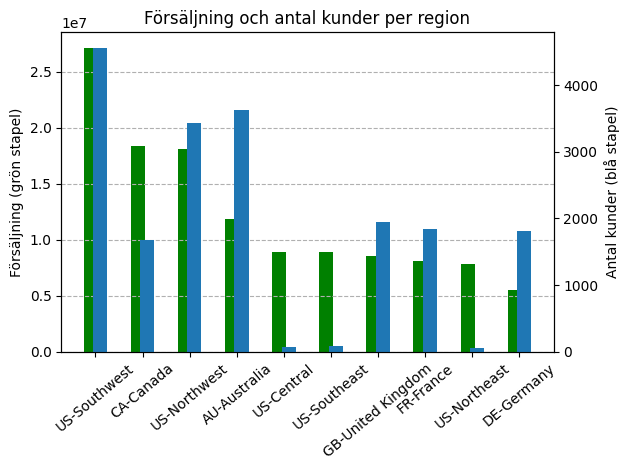

-----------------------------------------------
Högst försäljning: 27150595, region: US-Southwest
-----------------------------------------------
Lägst försäljning: 5479820, region: DE-Germany 
-----------------------------------------------
Flest unika kunder: 4565, region: US-Southwest
----------------------------------------
Minst unika kunder: 57, region: US-Northeast


In [21]:
q6 = """
SELECT CONCAT(sst.CountryRegionCode,'-', sst.Name) AS Region,
        SUM(ssoh.TotalDue) AS TotalFörsäljning,
        COUNT(DISTINCT sc.CustomerID) AS AntalKunder
FROM Sales.SalesOrderHeader ssoh
INNER JOIN Sales.Customer sc
    ON ssoh.CustomerID = sc.CustomerID
INNER JOIN Sales.SalesTerritory sst
    ON ssoh.TerritoryID = sst.TerritoryID
GROUP BY sst.CountryRegionCode, sst.Name
ORDER BY TotalFörsäljning DESC;"""
q6_df = query_df(q6)
# q6_df

x = np.arange(len(q6_df))
fig, ax = plt.subplots()
ax.bar(x - width/3, q6_df["TotalFörsäljning"], width=0.3, color='green')

ax2 = ax.twinx()
ax2.bar(x + width/3, q6_df["AntalKunder"], width=0.3)
ax.set_ylabel("Försäljning (grön stapel)")
ax2.set_ylabel("Antal kunder (blå stapel)")
ax.set_title("Försäljning och antal kunder per region")
ax.set_xticks(x, q6_df["Region"], rotation=40)
ax.grid(True, axis='y', linestyle='--')
plt.tight_layout()
plt.show()

# Winners & Losers..
max_sales = q6_df.loc[q6_df.TotalFörsäljning.idxmax()]
min_sales = q6_df.loc[q6_df.TotalFörsäljning.idxmin()]
max_customers = q6_df.loc[q6_df.AntalKunder.idxmax()]
min_customers = q6_df.loc[q6_df.AntalKunder.idxmin()]
print("-----------------------------------------------")
print(f"""Högst försäljning: {max_sales.TotalFörsäljning.round(0).astype(int)}, region: {max_sales.Region}""")
print("-----------------------------------------------")
print(f"""Lägst försäljning: {min_sales.TotalFörsäljning.round(0).astype(int)}, region: {min_sales.Region} """)
print("-----------------------------------------------")
print(f"""Flest unika kunder: {max_customers.AntalKunder.astype(int)}, region: {max_customers.Region}""")
print("----------------------------------------")
print(f"""Minst unika kunder: {min_customers.AntalKunder.astype(int)}, region: {min_customers.Region}""")

I grafen syns regioner och deras försäljning och antal unika kunder.

Insikter som fås är bland annat vilka kunder som gör flest orders eller driver mest intäkter framgår inte, fast grafen visar att Southwest i US driver in många ordrar och försäljning, medan till exempel Australien och US-Central driver mycket intäkter jämfört med antalet ordrar. Det sistnämnda föreslår att där finns mera stora kunder (företag) som lägger stora ordrar, förhållandevis. 

Bortsett från högst kunder och försäljning som tillföll US-Southwest är Tyskland där det säljs minst trots stora antalet kunder, som är tvärtom Australien och US-Central som alltså hade mycket intäkter på få kunder som troligtvis är privata konsumenter. 

## 3.7 Genomsnittligt ordervärde per region och kundtyp

Vilka regioner har högst/lägst genomsnittligt ordervärde och hur skiljer det sig mellan individuella kunder och företagskunder?

* *Metod:* 

Customers är 19820 rader, 18484 har personnummer och 1336 har butiknummer. INNER JOIN räcker för SalesOrderHeader, Customer och SalesTerritory tabellerna, samtidigt som LEFT JOIN på Customers behövs för vissa är företag och andra privatpersoner. Som i *3.6* konkateneras land och region. Division av summerade ordervärden med antal ordrar beräknar genomsnittligt ordervärde. CASE används i SELECT och GROUP BY för att få genomsnitten separata utefter sortens kund.

---------------------------------------------------
Högsta store ordersnitt: US-Southwest, 27739.1
Lägsta store ordersnitt : AU-Australia, 14415.8
---------------------------------------------------
Högsta individual ordersnitt: AU-Australia, 1490.4
Lägsta individual ordersnitt: US-Central, 368.4
---------------------------------------------------


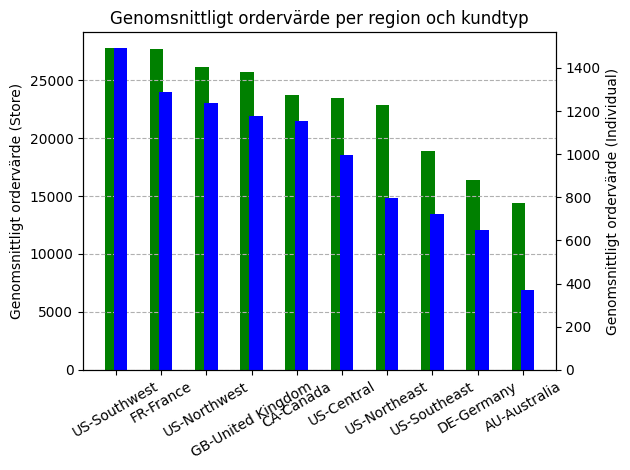

In [ ]:
q7 = """
SELECT CONCAT(sst.CountryRegionCode,'-', sst.Name) AS Region,
    CASE
    WHEN sc.StoreID IS NULL THEN 'Individual' ELSE 'Store' END AS Kund,

    SUM(ssoh.TotalDue) / COUNT(ssoh.SalesOrderID) AS Snittvärde
FROM Sales.SalesOrderHeader ssoh
INNER JOIN Sales.Customer sc
    ON ssoh.CustomerID = sc.CustomerID
LEFT JOIN Sales.Store ss
    ON sc.StoreID = ss.BusinessEntityID
INNER JOIN Sales.SalesTerritory sst
    ON sc.TerritoryID = sst.TerritoryID
GROUP BY CONCAT(sst.CountryRegionCode,'-', sst.Name),
    CASE
    WHEN sc.StoreID IS NULL THEN 'Individual' ELSE 'Store' END
ORDER BY Snittvärde DESC;"""
q7_df = query_df(q7)
# q7_df.head(3)
# len(q7_df) # 20 lång

# Winners & Losers..
store_df = q7_df[q7_df['Kund'] == 'Store']
ind_df = q7_df[q7_df['Kund'] == 'Individual']
max_store = store_df.loc[store_df['Snittvärde'].idxmax()]
min_store = store_df.loc[store_df['Snittvärde'].idxmin()]
max_ind = ind_df.loc[ind_df['Snittvärde'].idxmax()]
min_ind = ind_df.loc[ind_df['Snittvärde'].idxmin()]
print("---------------------------------------------------")
print(f"Högsta store ordersnitt: {max_store.Region}, {max_store.Snittvärde.round(1)}")
print(f"Lägsta store ordersnitt : {min_store.Region}, {min_store.Snittvärde.round(1)}")
print("---------------------------------------------------")
print(f"Högsta individual ordersnitt: {max_ind.Region}, {max_ind.Snittvärde.round(1)}")
print(f"Lägsta individual ordersnitt: {min_ind.Region}, {min_ind.Snittvärde.round(1)}")
print("---------------------------------------------------")


#     Grupperad stapelgraf..
# Ta fram geografier sammansättandes privata- och företagskunder:
regiontotal_desc = q7_df.groupby('Region')['Snittvärde'].sum().sort_values(ascending=False)

x = np.arange(len(regiontotal_desc))
store = q7_df[q7_df['Kund'] == 'Store']['Snittvärde']
individual = q7_df[q7_df['Kund'] == 'Individual']['Snittvärde']

fig, ax = plt.subplots()

# Store på vänster y-axel
ax.bar(x - width/3, store, width, color='green', label='Store') # width är 0.3 från innan
ax.set_ylabel('Genomsnittligt ordervärde (Store)')
ax.set_xticks(range(len(regiontotal_desc)))
ax.set_xticklabels(regiontotal_desc.index, rotation=30)
ax.grid(True, axis='y', linestyle='--')

ax2 = ax.twinx()
ax2.bar(x + width/3, individual, width, label='Individual')
ax2.set_ylabel('Genomsnittligt ordervärde (Individual)')

plt.title('Genomsnittligt ordervärde per region och kundtyp')
plt.tight_layout()
plt.show()

Regionernas privata och företagskunder slogs ihop så fallande ordning på stapelgrafen blir rättvis (vilket erfodrade sättande av xticklabel), även en sekundär y-axel var välbehövlig. Grafen visar att företagen lägger större ordrar än individer, och med *3.6* analysen i förra delkapitlet syntes det att regioner hade mixad dynamik gällande antal kunder. Utan att granska sådan här data på flera perspektiv är det olika insikter som kan missas. 

I den numeriska specifikationen på högsta och lägsta regioner framgår skillnad mellan kundtyperna, medan kunder per region matchar grafen ovan gällande att Australien hade mycket intäkter jämfört med antal kunder. I Australien är företagen i framkant för intäkterna, så dessa synvinklar matchar varann. US-Northwest hade dock mycket kunder per region medan det inte sticker ut i denna grafen. Det går att lära sig mera, med flera perspektiv via uppdelningar, såsom mellan avvecklade produkter eller aktiva, och så vidare. 

Skillnader som förekommit i regional analys i *3.6* och *3.7* har ofta att göra med exempelvis om det är stora fjärrlager med försäljning för företag, eller om det är stora antal privatpersoner som handlar i befolkningstäta områden. 

## 3.8 Regional Försäljningsoptimering

## 4. Reflektion

## 5. Sammanfattning